# 0. Imports

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, TomekLinks

# 1. Wstępna analiza danych

<AxesSubplot: ylabel='Frequency'>

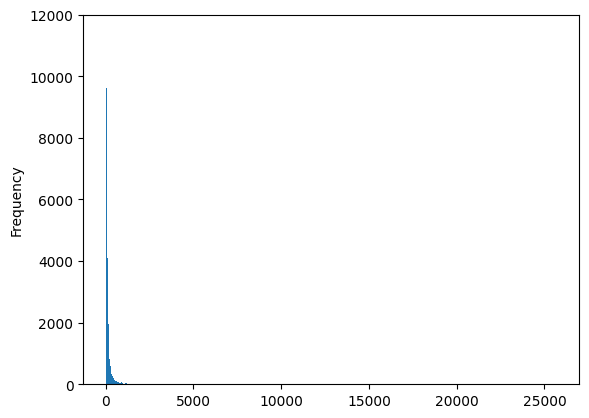

In [3]:
credit_csv = pd.read_csv('creditcard.csv')
#print(credit_csv['Amount'].value_counts())
credit_csv['Amount'].plot.hist(bins=4000, ylim=(0, 12000))

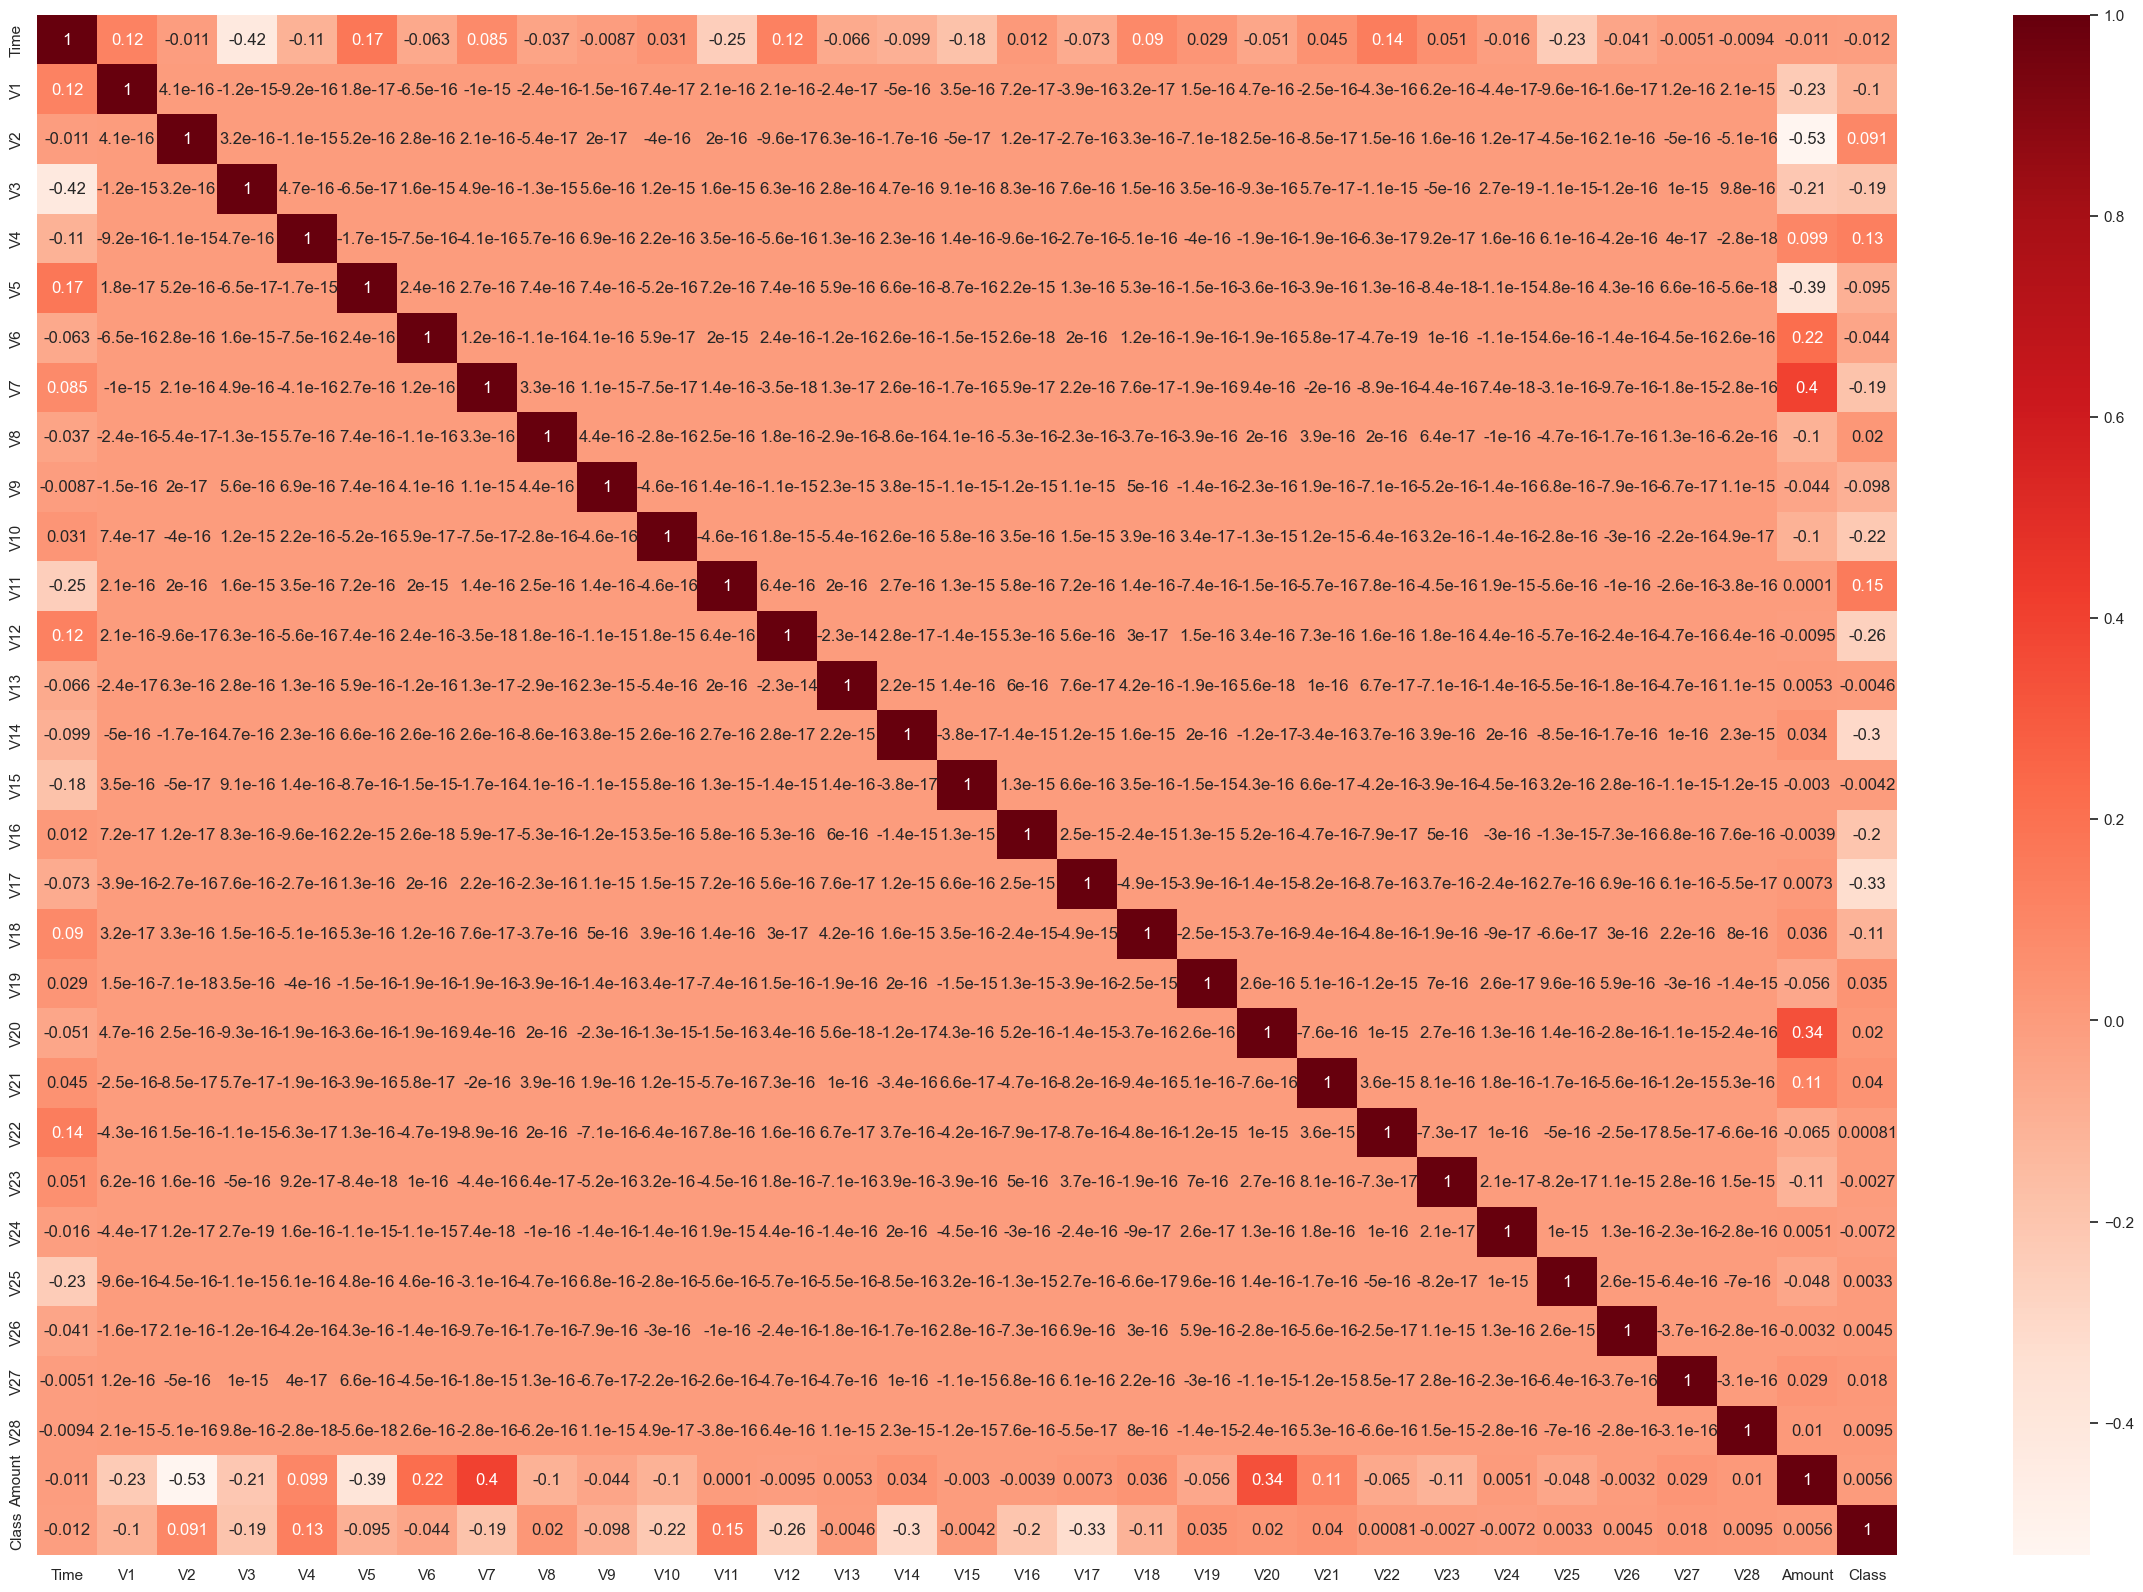

In [3]:
credit_csv = pd.read_csv('creditcard.csv')
corr_matrix = credit_csv.corr()
#print(corr_matrix)

sn.set(rc={'figure.figsize':(30,20)})
sn.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

# 2. Wstępne przetwarzanie danych

In [4]:
credit_csv = pd.read_csv('creditcard.csv')
print(credit_csv.shape)

index_credit = credit_csv[(credit_csv['Amount'] == 0) & (credit_csv['Class'] == 0)].index
credit_csv.drop(index_credit, inplace=True)
print(credit_csv.shape)

(284807, 31)
(283009, 31)


(260106, 31)


<AxesSubplot: ylabel='Frequency'>

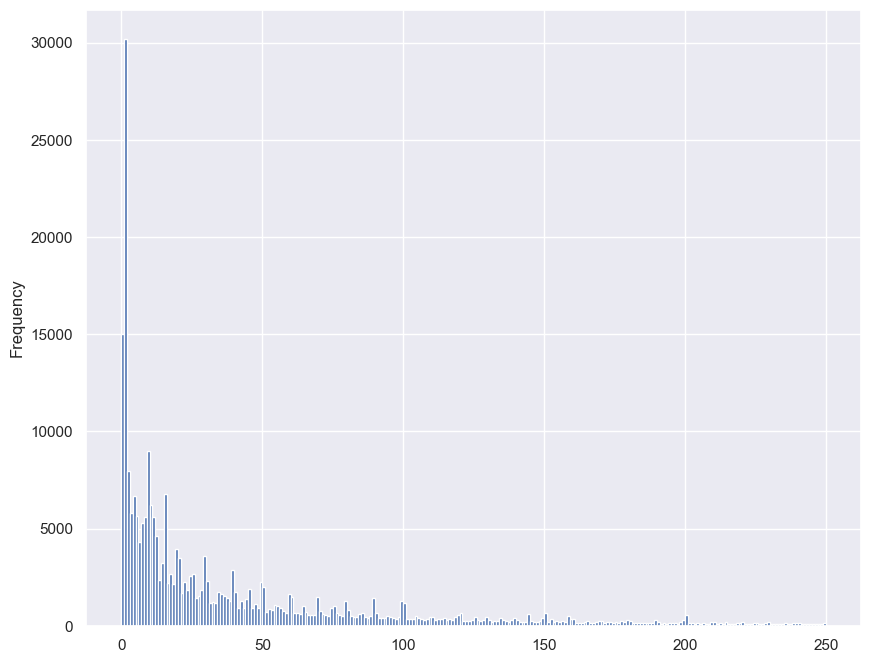

In [5]:
credit_csv_corrected = credit_csv[credit_csv.Amount < 250]
print(credit_csv_corrected.shape)
sn.set(rc={'figure.figsize':(10,8)})
credit_csv_corrected['Amount'].plot.hist(bins=250)

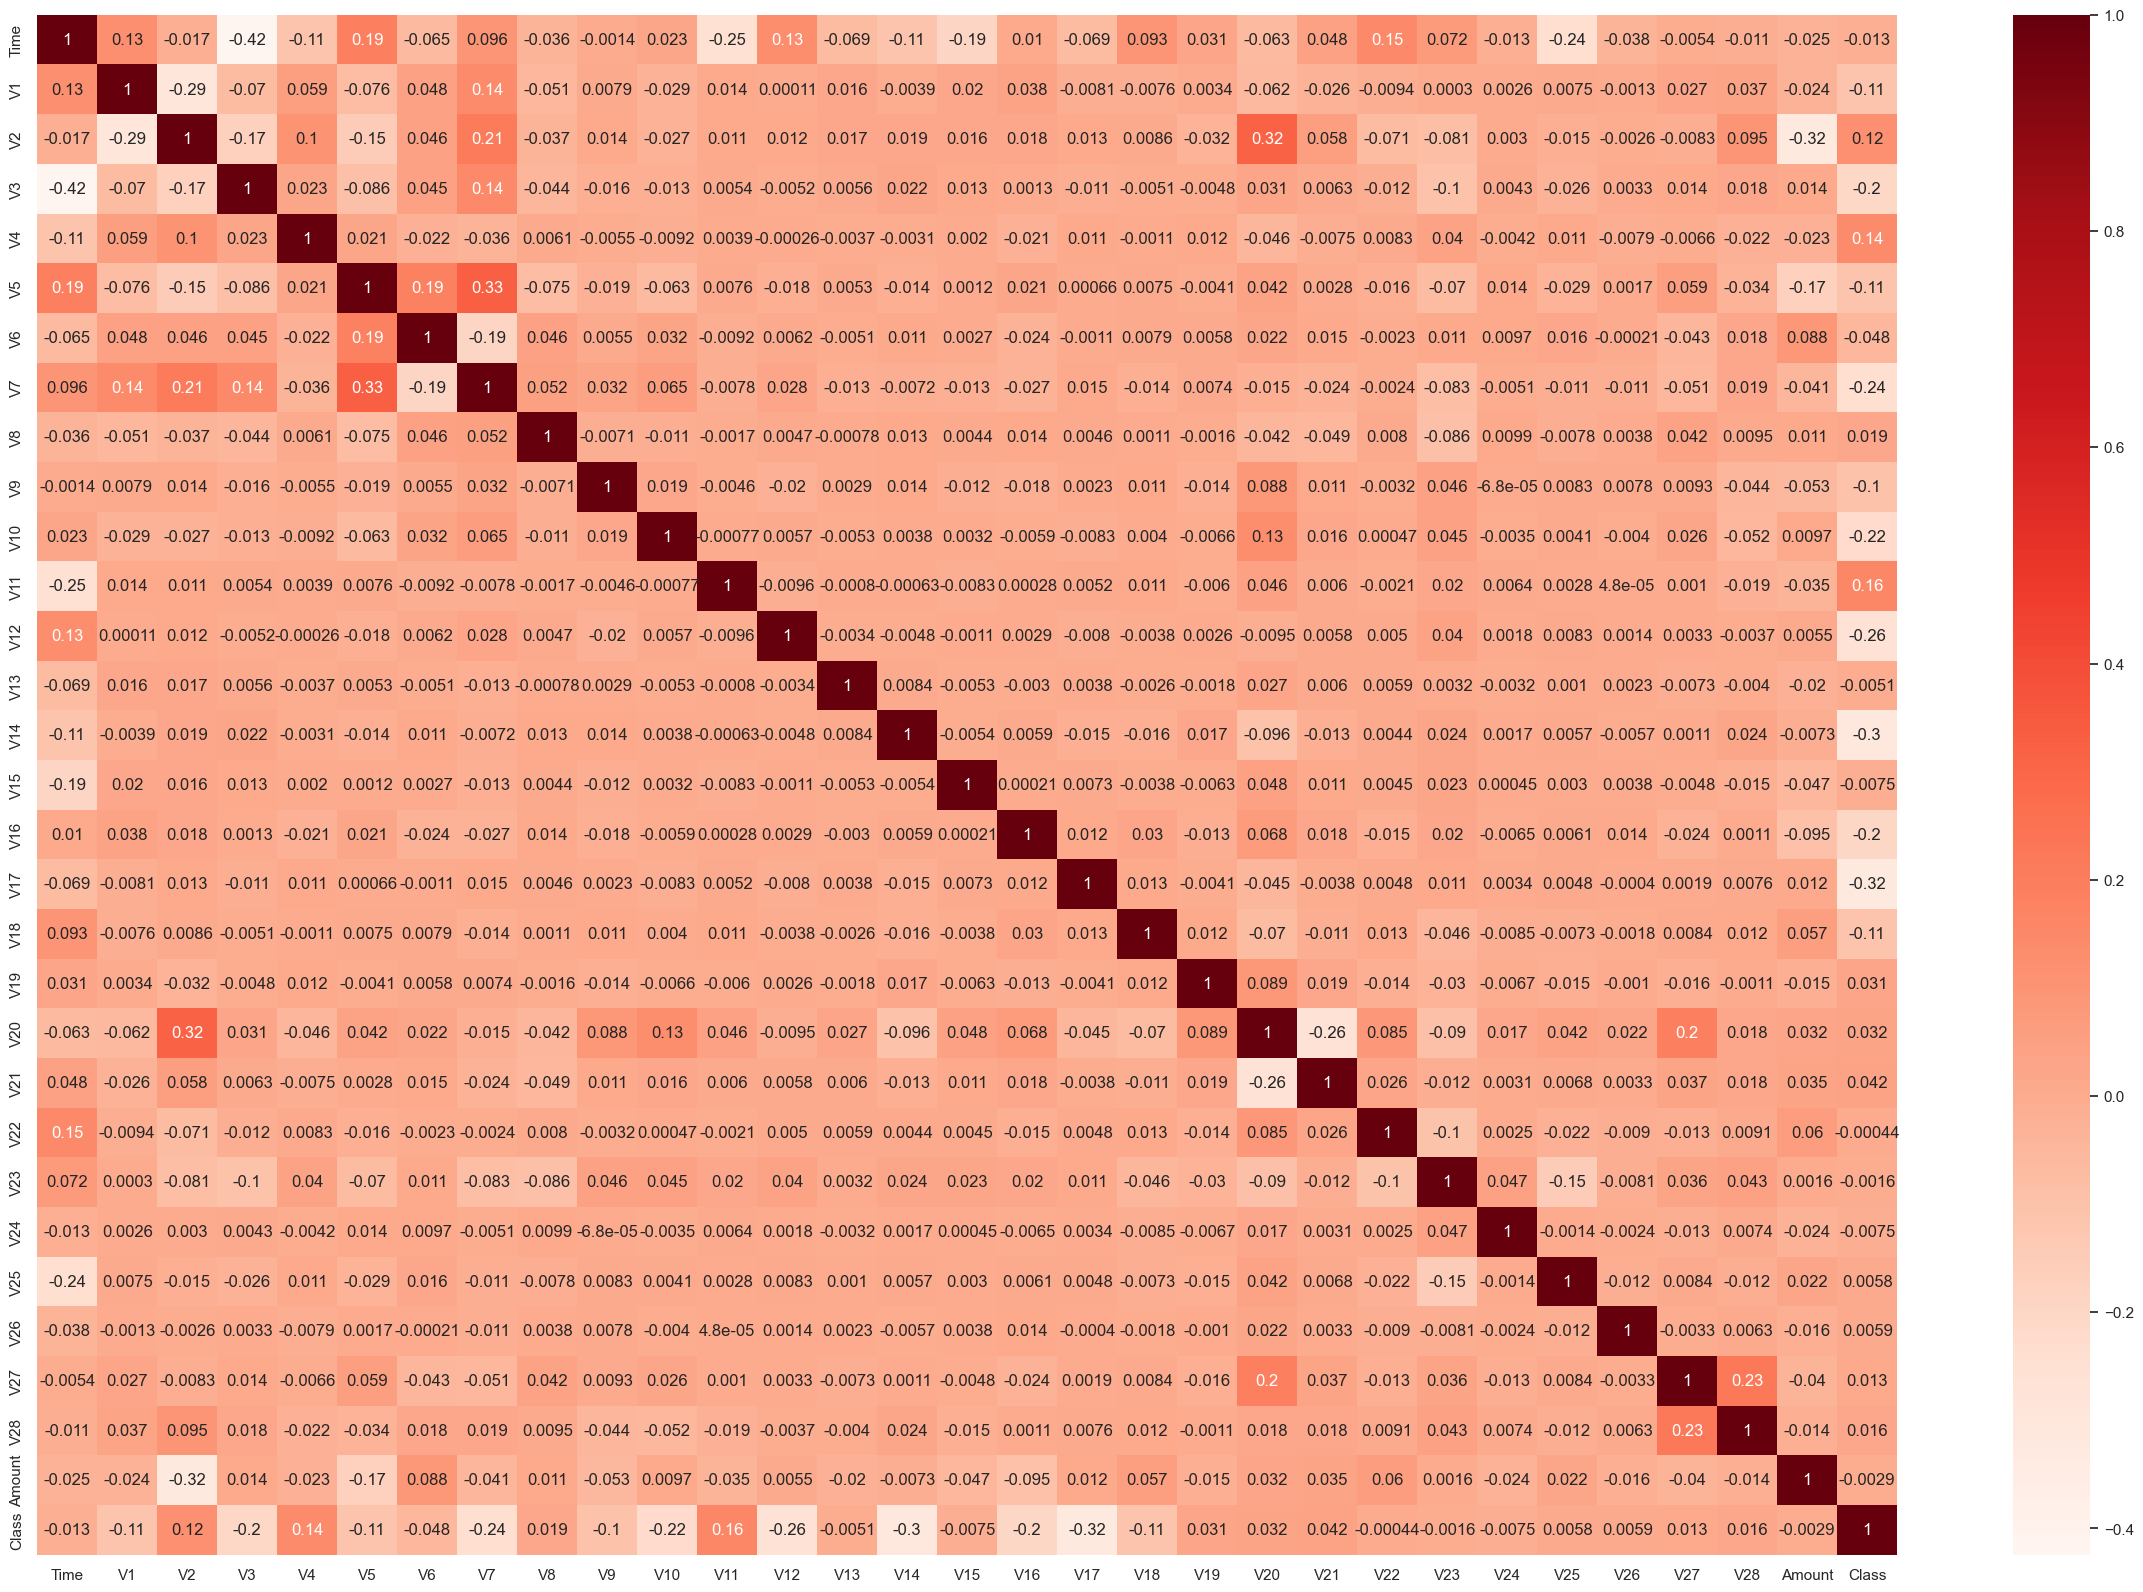

In [6]:
corr_matrix = credit_csv_corrected.corr()
sn.set(rc={'figure.figsize':(30,20)})
sn.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
corr_target_time = abs(corr_matrix['Time'])
corr_target_amount = abs(corr_matrix['Amount'])

relevant_columns_time = corr_target_time[abs(corr_target_time) < 0.1]
relevant_columns_amount = corr_target_amount[abs(corr_target_amount) < 0.1]

relevant_full = pd.concat([relevant_columns_time, relevant_columns_amount], axis=1).dropna().index.to_list()
relevant_full.append('Time')
relevant_full.append('Amount')

print(relevant_full)

credit_csv_final = credit_csv_corrected[relevant_full]
#credit_csv_final.to_csv('creditcard_processed.csv', index=False)

['V6', 'V7', 'V8', 'V9', 'V10', 'V13', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Class', 'Time', 'Amount']


# 3. F-measure, TRP and Precision for Fradulent Transactions using a Decision Tree, Random Forest and Linear Regression Models

## DecisionTree

In [8]:
def DecisionTreeMeasures(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(random_state=1234)
    
    parameters = {'max_depth':(5, 9, 13), 'min_samples_split':(4, 16, 64)}
    model_params = GridSearchCV(model, parameters)
    model_params.fit(X_train, y_train)

    predictions = model_params.predict(X_test)

    conf_mat = confusion_matrix(y_test, predictions)
    recall = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
    precision = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
    f_score = 2 * precision * recall / (precision + recall)
    print(conf_mat)
    print(f'True Positive Rate for Class 1: {recall}')
    print(f'Precision for Class 1: {precision}')
    print(f'F-Score for Class 1: {f_score}')

In [9]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class'].values
y = credit_csv['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22075)

DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51937     6]
 [   16    63]]
True Positive Rate for Class 1: 0.7974683544303798
Precision for Class 1: 0.9130434782608695
F-Score for Class 1: 0.8513513513513514


## RandomForest

In [66]:
def RandomForestMeasures(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=20, random_state=1234)
    
    parameters = {'max_depth':(5, 9, 13), 'min_samples_split':(4, 16, 64)}
    model_params = GridSearchCV(model, parameters)
    model_params.fit(X_train, y_train)

    predictions = model_params.predict(X_test)

    conf_mat = confusion_matrix(y_test, predictions)
    recall = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
    precision = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
    f_score = 2 * precision * recall / (precision + recall)
    print(conf_mat)
    print(f'True Positive Rate for Class 1: {recall}')
    print(f'Precision for Class 1: {precision}')
    print(f'F-Score for Class 1: {f_score}')

In [46]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class'].values
y = credit_csv['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22075)

RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51940     3]
 [   19    60]]
True Positive Rate for Class 1: 0.759493670886076
Precision for Class 1: 0.9523809523809523
F-Score for Class 1: 0.8450704225352113


## Logistic Regression

In [53]:
def LogisticRegressionMeasures(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=500, solver='lbfgs', random_state=9921)
    
    parameters = {'C':(0.1, 0.25, 0.5, 1, 2, 4)}
    model_params = GridSearchCV(model, parameters)
    model_params.fit(X_train, y_train)

    predictions = model_params.predict(X_test)

    conf_mat = confusion_matrix(y_test, predictions)
    recall = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
    precision = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
    f_score = 2 * precision * recall / (precision + recall)
    print(conf_mat)
    print(f'True Positive Rate for Class 1: {recall}')
    print(f'Precision for Class 1: {precision}')
    print(f'F-Score for Class 1: {f_score}')

In [54]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class'].values
y = credit_csv['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22075)

LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[51936     7]
 [   34    45]]
True Positive Rate for Class 1: 0.569620253164557
Precision for Class 1: 0.8653846153846154
F-Score for Class 1: 0.6870229007633588


# 4. Algorytmy balansowania danych: SMOTE, Undersampling, Oversampling

#### Random Undersampling

In [55]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=5678)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print(df_downsampled.Class.value_counts())

0    330
1    330
Name: Class, dtype: int64


In [61]:
X_train = df_downsampled.loc[:, df_downsampled.columns != 'Class']
y_train = df_downsampled['Class']

DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[49130  2804]
 [   14    74]]
True Positive Rate for Class 1: 0.8409090909090909
Precision for Class 1: 0.02571230020847811
F-Score for Class 1: 0.04989885367498314


In [60]:
X_train = df_downsampled.loc[:, df_downsampled.columns != 'Class']
y_train = df_downsampled['Class']

RandomForestMeasures(X_train, y_train, X_test, y_test)

[[50699  1235]
 [   15    73]]
True Positive Rate for Class 1: 0.8295454545454546
Precision for Class 1: 0.05581039755351682
F-Score for Class 1: 0.10458452722063037


In [56]:
X_train = df_downsampled.loc[:, df_downsampled.columns != 'Class']
y_train = df_downsampled['Class']

LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[49260  2674]
 [   13    75]]
True Positive Rate for Class 1: 0.8522727272727273
Precision for Class 1: 0.02728264823572208
F-Score for Class 1: 0.052872752908001405


#### CNN + Tomek Links

In [67]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2654)

tomek = TomekLinks(sampling_strategy='majority')
cnn = CondensedNearestNeighbour(sampling_strategy='majority', random_state=2654)

X_train, y_train = tomek.fit_resample(X_train, y_train)
X_train, y_train = cnn.fit_resample(X_train, y_train)

In [68]:
DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51702   234]
 [   11    75]]
True Positive Rate for Class 1: 0.872093023255814
Precision for Class 1: 0.24271844660194175
F-Score for Class 1: 0.37974683544303794


In [69]:
RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51833   103]
 [   10    76]]
True Positive Rate for Class 1: 0.8837209302325582
Precision for Class 1: 0.4245810055865922
F-Score for Class 1: 0.5735849056603773


In [70]:
LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[51567   369]
 [   18    68]]
True Positive Rate for Class 1: 0.7906976744186046
Precision for Class 1: 0.15560640732265446
F-Score for Class 1: 0.260038240917782


#### Random Oversampling

In [57]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=38)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print(df_upsampled.Class.value_counts())

0    207744
1    207744
Name: Class, dtype: int64


In [62]:
X_train = df_upsampled.loc[:, df_upsampled.columns != 'Class']
y_train = df_upsampled['Class']

DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51611   323]
 [    6    82]]
True Positive Rate for Class 1: 0.9318181818181818
Precision for Class 1: 0.20246913580246914
F-Score for Class 1: 0.332657200811359


In [63]:
X_train = df_upsampled.loc[:, df_upsampled.columns != 'Class']
y_train = df_upsampled['Class']

RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51931     3]
 [    4    84]]
True Positive Rate for Class 1: 0.9545454545454546
Precision for Class 1: 0.9655172413793104
F-Score for Class 1: 0.96


In [58]:
X_train = df_upsampled.loc[:, df_upsampled.columns != 'Class']
y_train = df_upsampled['Class']

LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[49299  2645]
 [    9    69]]
True Positive Rate for Class 1: 0.8846153846153846
Precision for Class 1: 0.025423728813559324
F-Score for Class 1: 0.04942693409742121


#### Naive Resampling

In [59]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1112)

over = RandomOverSampler(sampling_strategy=0.2, random_state=12345)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=12345)

X_train, y_train = over.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)

In [82]:
DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51771   154]
 [   19    78]]
True Positive Rate for Class 1: 0.8041237113402062
Precision for Class 1: 0.33620689655172414
F-Score for Class 1: 0.4741641337386018


In [83]:
RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51915    10]
 [   19    78]]
True Positive Rate for Class 1: 0.8041237113402062
Precision for Class 1: 0.8863636363636364
F-Score for Class 1: 0.8432432432432433


In [60]:
LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[51457   468]
 [   20    77]]
True Positive Rate for Class 1: 0.7938144329896907
Precision for Class 1: 0.14128440366972478
F-Score for Class 1: 0.2398753894080997


#### SMOTE

In [61]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9987)

oversample = SMOTE(sampling_strategy='minority', random_state=2137)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [67]:
DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51521   429]
 [   10    62]]
True Positive Rate for Class 1: 0.8611111111111112
Precision for Class 1: 0.12627291242362526
F-Score for Class 1: 0.2202486678507993


In [68]:
RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51934    16]
 [    8    64]]
True Positive Rate for Class 1: 0.8888888888888888
Precision for Class 1: 0.8
F-Score for Class 1: 0.8421052631578948


In [62]:
LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[49381  2569]
 [    6    66]]
True Positive Rate for Class 1: 0.9166666666666666
Precision for Class 1: 0.025047438330170778
F-Score for Class 1: 0.048762467676394534


#### SMOTE z Undersampling klasy większościowej

In [63]:
credit_csv = pd.read_csv('creditcard_processed.csv')

X = credit_csv.loc[:, credit_csv.columns != 'Class']
y = credit_csv['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6767)

over = SMOTE(sampling_strategy=0.1, random_state=1654)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=1654)

X_train, y_train = over.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)

In [88]:
DecisionTreeMeasures(X_train, y_train, X_test, y_test)

[[51442   498]
 [    7    75]]
True Positive Rate for Class 1: 0.9146341463414634
Precision for Class 1: 0.13089005235602094
F-Score for Class 1: 0.22900763358778625


In [89]:
RandomForestMeasures(X_train, y_train, X_test, y_test)

[[51916    24]
 [    8    74]]
True Positive Rate for Class 1: 0.9024390243902439
Precision for Class 1: 0.7551020408163265
F-Score for Class 1: 0.8222222222222222


In [64]:
LogisticRegressionMeasures(X_train, y_train, X_test, y_test)

[[50448  1492]
 [   10    72]]
True Positive Rate for Class 1: 0.8780487804878049
Precision for Class 1: 0.04603580562659847
F-Score for Class 1: 0.08748481166464156
